**OPTIMIZE THE IMAGE RECOGNITION TASK ON CIFAR-10 DATASET WITH PYTORCH**

Introduction

Image recognition remains a cornerstone problem in the domain of artificial intelligence and deep learning, demanding sophisticated and optimized solutions. Although convolutional neural networks (CNNs) have become the de facto standard for image-related tasks due to their superior performance, fully connected networks (FCNs) still serve as a fundamental baseline and are crucial for understanding the core mechanics of neural networks.

In this project, we aim to develop and optimize a FCN) to classify images from the CIFAR-10 dataset. This endeavor not only reinforces foundational deep learning concepts but also demonstrates the practical application and limitations of FCNs in image recognition tasks.

We leverage PyTorch, a highly versatile and powerful deep learning framework, to implement our model. PyTorch's library make it an ideal choice for deployment of neural networks.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 64

CIFAR-10

This dataset is a popular benchmark for image classification tasks. It is a subset of the 80 million tiny images dataset and consists of 50,000 32x32 RGB color images containing one of 10 object classes, with 6000 images per class.

For this project, we will start at splitting the dataset into training, validation, and test sets in a 6:2:2 ratio, ensuring robust model evaluation and fine-tuning.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load CIFAR10 dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Define split ratios for training, validation, and test sets (e.g., 60% train, 20% validation, 20% test)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Generate random indices for splitting the dataset
dataset_size = len(train_data)
indices = list(range(dataset_size))
torch.manual_seed(42)  # For reproducibility
shuffle_indices = torch.randperm(dataset_size)

# Split data based on ratios
train_idx = shuffle_indices[:int(train_ratio * dataset_size)]
val_idx = shuffle_indices[int(train_ratio * dataset_size): int((train_ratio + val_ratio) * dataset_size)]
test_idx = shuffle_indices[int((train_ratio + val_ratio) * dataset_size):]

# Create train, validation, and test datasets using the indices
train_dataset = torch.utils.data.Subset(train_data, train_idx)
val_dataset = torch.utils.data.Subset(train_data, val_idx)
test_dataset = torch.utils.data.Subset(train_data, test_idx)

# Create samplers for each dataset
train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
val_sampler = torch.utils.data.sampler.SequentialSampler(val_dataset)
test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)

# Create data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

# Print information about the data loaders
print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")
print(f"Test data size: {len(test_dataset)}")

100%|██████████| 170498071/170498071 [00:04<00:00, 34795488.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Training data size: 30000
Validation data size: 10000
Test data size: 10000


In [ ]:
len(train_data)

50000

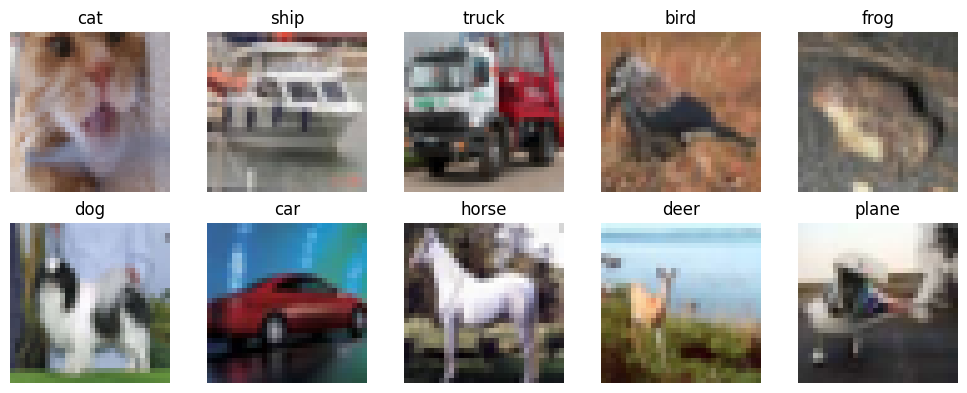

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis
    plt.show()

# Show one image for each class
class_images = {class_name: None for class_name in classes}

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

for ax_row in axes:
    for ax in ax_row:
        images, labels = next(iter(train_loader))
        for i in range(len(labels)):
            class_name = classes[labels[i]]
            if class_images[class_name] is None:
                class_images[class_name] = images[i]
                ax.imshow(np.transpose(images[i] / 2 + 0.5, (1, 2, 0)))
                ax.set_title(class_name)
                ax.axis('off')  # Turn off axis
                break

plt.tight_layout()
plt.show()

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        # Flatten the input image (32x32x3) to a 1D vector
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)  # 10 classes for CIFAR-10


    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x


In [ ]:
model = FCNet()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

val_loss_list = []
val_acc_list = []
train_loss_list = []
train_acc_list = []

# Training loop with validation
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct_train = 0
    total_train = 0
    val_correct = 0
    val_total = 0
    # Train the model
    model.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels
        inputs, labels = data

        # Clear gradients for each training step
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Print statistics
        train_loss += loss.item()
        if i % 100 == 99:
            train_loss = 0.0
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    # Validate the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)


    # Calculate and print validation accuracy
    val_loss = val_loss / len(val_loader)
    train_loss = train_loss / len(train_loader)
    val_acc = val_correct / val_total
    train_acc = correct_train / total_train

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.3f} | Train Accuracy: {100 * train_acc:.2f} | Validation Loss: {val_loss:.3f} | Validation Accuracy: {100 * val_acc:.2f}")

print("Done!")

Epoch 1: Train Loss: 0.238 | Train Accuracy: 38.13 | Validation Loss: 1.630 | Validation Accuracy: 42.18
Epoch 2: Train Loss: 0.217 | Train Accuracy: 46.47 | Validation Loss: 1.535 | Validation Accuracy: 46.22
Epoch 3: Train Loss: 0.202 | Train Accuracy: 51.12 | Validation Loss: 1.455 | Validation Accuracy: 48.94
Epoch 4: Train Loss: 0.191 | Train Accuracy: 54.01 | Validation Loss: 1.453 | Validation Accuracy: 49.77
Epoch 5: Train Loss: 0.182 | Train Accuracy: 57.41 | Validation Loss: 1.455 | Validation Accuracy: 49.40
Epoch 6: Train Loss: 0.169 | Train Accuracy: 60.41 | Validation Loss: 1.461 | Validation Accuracy: 50.48
Epoch 7: Train Loss: 0.153 | Train Accuracy: 62.88 | Validation Loss: 1.508 | Validation Accuracy: 49.95
Epoch 8: Train Loss: 0.148 | Train Accuracy: 66.02 | Validation Loss: 1.522 | Validation Accuracy: 51.58
Epoch 9: Train Loss: 0.127 | Train Accuracy: 68.56 | Validation Loss: 1.612 | Validation Accuracy: 50.68
Epoch 10: Train Loss: 0.123 | Train Accuracy: 71.50 | V

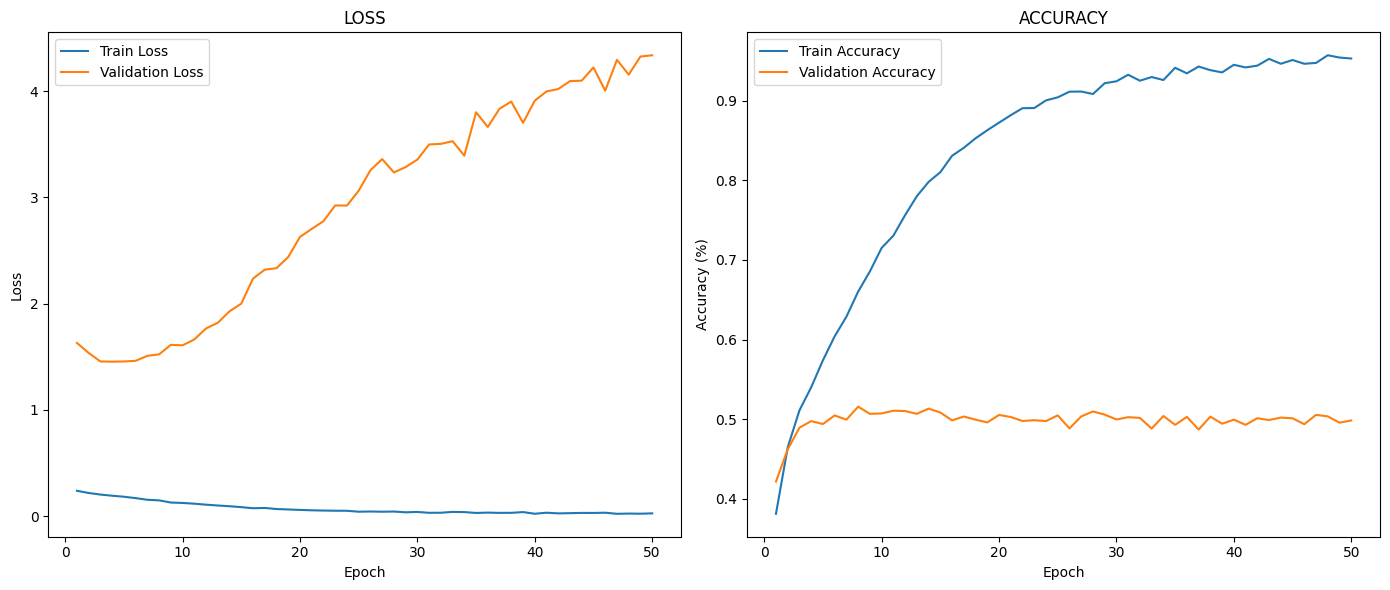

In [ ]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOSS')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ACCURACY')
plt.legend()

plt.tight_layout()
plt.show()

### **First Performance Review**

**Accuracy Part**: The training accuracy increases steadily throughout the training process, reaching a maximum of 95.69% at epoch 48. This indicates that the model is learning the training data well. The validation accuracy fluctuates throughout the training process. This indicates a issue of overfitting. The model might be memorizing the training data too well and not generalizing well to unseen data.

**Loss Part**: The training loss follows a similar trend, decreasing steadily as the model improves. This suggests the network is optimizing its parameters to minimize the loss function. While the validation loss doesn't show a clear downward trend, the high values compared to training loss further support the possibility of overfitting.

# **Second Take**

The previous results accuracy suggests a overfitting problem. Consider implementing techniques to address overfitting, such as:


*   Early stopping: Stop training when the validation accuracy plateaus or starts to decrease.
*   Dropout: Randomly drop neurons during training to prevent co-adaptation and encourage the network to learn more robust features.

In the other hands, seem the training speed is quiet slow, we consider some method to improve the performance:

*   Raise the batch size: We start at size_batch 64 (a normal size), we will raise the size_batch to get faster at training.
*   Upgrade the structure of fully connected by modify the neurals from hidden layer in the model.

In [ ]:
# Define hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 512    # Increase the size_batch to get faster at training

class FCNet_2take(nn.Module):
    def __init__(self):
        super(FCNet_2take, self).__init__()
        # Flatten the input image (32x32x3) to a 1D vector
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)      # Add more layer
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)        # 10 classes for CIFAR-10
        self.dropout = nn.Dropout(0.3)      # Add drop out


    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc6(x), dim=1)
        return x

model = FCNet_2take()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

val_loss_list2 = []
val_acc_list2 = []
train_loss_list2 = []
train_acc_list2 = []

# Early stopping param
best_val_acc = 0.0
patience = 5
current_patience = 0

# Training loop with validation
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct_train = 0
    total_train = 0
    val_correct = 0
    val_total = 0
    # Train the model
    model.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels
        inputs, labels = data

        # Clear gradients for each training step
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Print statistics
        train_loss += loss.item()
        if i % 100 == 99:
            train_loss = 0.0
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    # Validate the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)


    # Calculate and print validation accuracy
    val_loss = val_loss / len(val_loader)
    train_loss = train_loss / len(train_loader)
    val_acc = val_correct / val_total
    train_acc = correct_train / total_train

    train_loss_list2.append(train_loss)
    train_acc_list2.append(train_acc)
    val_acc_list2.append(val_acc)
    val_loss_list2.append(val_loss)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.3f} | Train Accuracy: {100 * train_acc:.2f} | Validation Loss: {val_loss:.3f} | Validation Accuracy: {100 * val_acc:.2f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            print("Highest accuracy: ", best_val_acc * 100)
            break

print("Done!")

Epoch 1: Train Loss: 0.280 | Train Accuracy: 26.06 | Validation Loss: 1.812 | Validation Accuracy: 34.21
Epoch 2: Train Loss: 0.263 | Train Accuracy: 34.51 | Validation Loss: 1.719 | Validation Accuracy: 39.41
Epoch 3: Train Loss: 0.256 | Train Accuracy: 37.33 | Validation Loss: 1.651 | Validation Accuracy: 41.80
Epoch 4: Train Loss: 0.248 | Train Accuracy: 39.88 | Validation Loss: 1.622 | Validation Accuracy: 42.49
Epoch 5: Train Loss: 0.241 | Train Accuracy: 41.79 | Validation Loss: 1.592 | Validation Accuracy: 43.35
Epoch 6: Train Loss: 0.238 | Train Accuracy: 42.92 | Validation Loss: 1.574 | Validation Accuracy: 44.13
Epoch 7: Train Loss: 0.237 | Train Accuracy: 44.43 | Validation Loss: 1.536 | Validation Accuracy: 45.12
Epoch 8: Train Loss: 0.229 | Train Accuracy: 45.32 | Validation Loss: 1.526 | Validation Accuracy: 46.25
Epoch 9: Train Loss: 0.229 | Train Accuracy: 46.41 | Validation Loss: 1.532 | Validation Accuracy: 46.22
Epoch 10: Train Loss: 0.220 | Train Accuracy: 47.47 | V

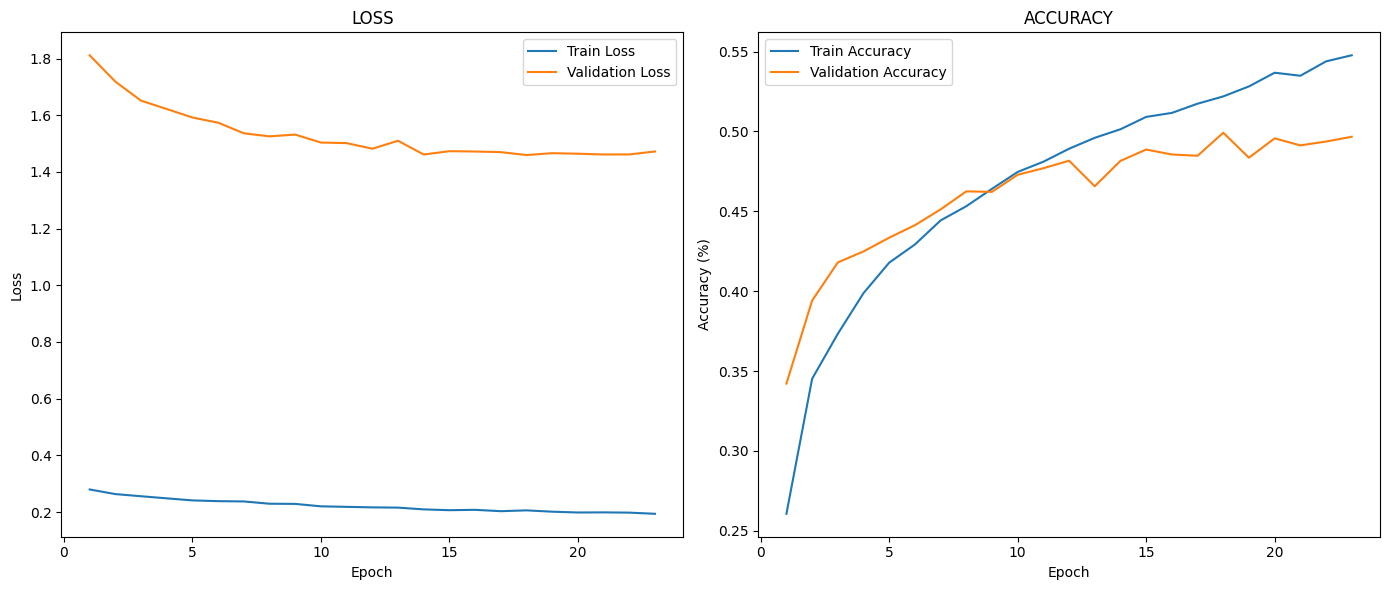

In [ ]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 2), train_loss_list2, label='Train Loss')
plt.plot(range(1, epoch + 2), val_loss_list2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOSS')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_acc_list2, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_acc_list2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ACCURACY')
plt.legend()

plt.tight_layout()
plt.show()

### **Second Performance Review**

It not faster than the first take at training step result (probably because of batch size changing), but seem the Validation Loss is begun to 'fluctuate' at a point (not sharply increase like 1st take).

Due to the early stopping method, the Validation Accuracy is a little bit dropping and show the sign of reduce overfitting. Then the results illustrates a underfitting issue when the train and validation accuracy are either low (~54% and ~49% respectively).

# **Third Take**

This performance will focus on increase the validation accuracy to avoid the underfit problem.

*   **L2 Regularization**: Penalizes the model for having large weights, encouraging simpler models that are less likely to overfit.
*   **Data Augmentation**: Artificially increase the size and diversity of the training data by applying random transformations (e.g., rotations, flips, ...) to existing data points.




In [ ]:
# Define hyperparameters
learning_rate = 0.001
epochs = 100
batch_size = 512

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

# Download and load CIFAR10 dataset
org_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Augment the dataset
augment = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=20),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augment_data = torchvision.datasets.CIFAR10(root='./augmentdata1', train=True,
                                        download=True, transform=augment)

train_data = torch.utils.data.ConcatDataset([org_data, augment_data])
# Define split ratios for training, validation, and test sets
train_ratio = 0.7           # Increase the train ratio to 0.7 instead of 0.6
val_ratio = 0.15
test_ratio = 0.15

# Generate random indices for splitting the dataset
dataset_size = len(train_data)
indices = list(range(dataset_size))
torch.manual_seed(42)  # For reproducibility
shuffle_indices = torch.randperm(dataset_size)

# Split data based on ratios
train_idx = shuffle_indices[:int(train_ratio * dataset_size)]
val_idx = shuffle_indices[int(train_ratio * dataset_size): int((train_ratio + val_ratio) * dataset_size)]
test_idx = shuffle_indices[int((train_ratio + val_ratio) * dataset_size):]

# Create train, validation, and test datasets using the indices
train_dataset = torch.utils.data.Subset(train_data, train_idx)
val_dataset = torch.utils.data.Subset(train_data, val_idx)
test_dataset = torch.utils.data.Subset(train_data, test_idx)

# Create samplers for each dataset
train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
val_sampler = torch.utils.data.sampler.SequentialSampler(val_dataset)
test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)

# Create data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

class FCNet_3take(nn.Module):
    def __init__(self):
        super(FCNet_3take, self).__init__()
        # Flatten the input image (32x32x3) to a 1D vector
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)      # Add more layer
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 32)
        self.fc6 = nn.Linear(32, 10)        # 10 classes for CIFAR-10
        self.dropout = nn.Dropout(0.3)      # Add drop out


    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc6(x), dim=1)
        return x

model = FCNet_3take()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)  # L2 Regularization
criterion = nn.CrossEntropyLoss()

val_loss_list3 = []
val_acc_list3 = []
train_loss_list3 = []
train_acc_list3 = []

# Early stopping param
best_val_acc = 0.0
patience = 10
current_patience = 0

# Training loop with validation
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct_train = 0
    total_train = 0
    val_correct = 0
    val_total = 0
    # Train the model
    model.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels
        inputs, labels = data

        # Clear gradients for each training step
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Print statistics
        train_loss += loss.item()
        if i % 100 == 99:
            train_loss = 0.0
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    # Validate the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)


    # Calculate and print validation accuracy
    val_loss = val_loss / len(val_loader)
    train_loss = train_loss / len(train_loader)
    val_acc = val_correct / val_total
    train_acc = correct_train / total_train

    train_loss_list3.append(train_loss)
    train_acc_list3.append(train_acc)
    val_acc_list3.append(val_acc)
    val_loss_list3.append(val_loss)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.3f} | Train Accuracy: {100 * train_acc:.2f} | Validation Loss: {val_loss:.3f} | Validation Accuracy: {100 * val_acc:.2f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            print("Highest accuracy: ", best_val_acc * 100)
            break

print("Done!")

100%|██████████| 170498071/170498071 [00:13<00:00, 12412107.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 170498071/170498071 [00:19<00:00, 8745332.94it/s]


Extracting ./augmentdata1/cifar-10-python.tar.gz to ./augmentdata1
Epoch 1: Train Loss: 2.056 | Train Accuracy: 23.08 | Validation Loss: 1.816 | Validation Accuracy: 34.86
Epoch 2: Train Loss: 1.840 | Train Accuracy: 33.83 | Validation Loss: 1.693 | Validation Accuracy: 39.72
Epoch 3: Train Loss: 1.738 | Train Accuracy: 38.53 | Validation Loss: 1.622 | Validation Accuracy: 42.67
Epoch 4: Train Loss: 1.678 | Train Accuracy: 40.76 | Validation Loss: 1.567 | Validation Accuracy: 44.69
Epoch 5: Train Loss: 1.640 | Train Accuracy: 42.19 | Validation Loss: 1.511 | Validation Accuracy: 46.95
Epoch 6: Train Loss: 1.604 | Train Accuracy: 43.66 | Validation Loss: 1.499 | Validation Accuracy: 46.83
Epoch 7: Train Loss: 1.584 | Train Accuracy: 44.66 | Validation Loss: 1.460 | Validation Accuracy: 47.67
Epoch 8: Train Loss: 1.568 | Train Accuracy: 45.12 | Validation Loss: 1.463 | Validation Accuracy: 47.79
Epoch 9: Train Loss: 1.549 | Train Accuracy: 45.99 | Validation Loss: 1.448 | Validation Accu

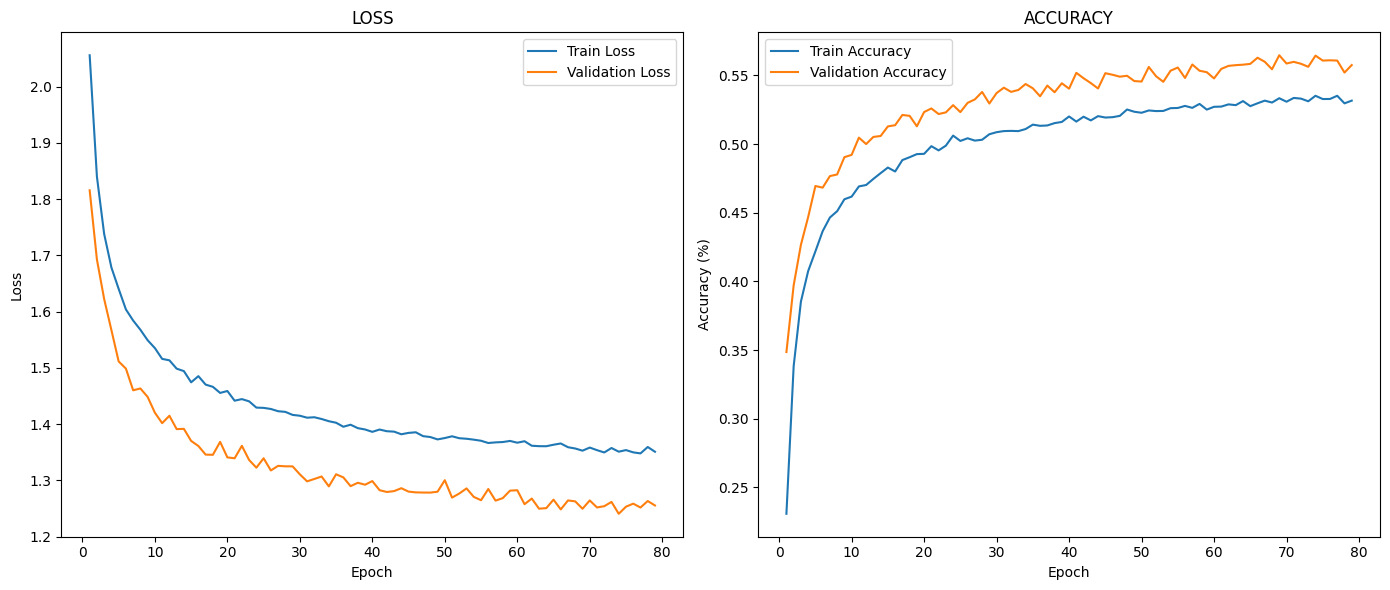

In [ ]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 80), train_loss_list3, label='Train Loss')
plt.plot(range(1, 80), val_loss_list3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOSS')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_acc_list3, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_acc_list3, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ACCURACY')
plt.legend()

plt.tight_layout()
plt.show()

### **Third Performance Review**

**Overall**: Both training and validation accuracy show a clear upward trend, indicating the model is learning the data effectively, however, the validation statistic show a bit more fluctuate than training ones.

**Validation Higher Than Training**: While validation accuracy is generally desirable, a consistent difference between validation and training accuracy can indicate overfitting. Here, validation accuracy surpasses training accuracy for most epochs, reaching a slightly higher maximum.

# **Fourth Take**

So from the previous take, we desired a lower training results than validation. In this take, we will give more data from validation data to training data, also change the Adam optimizer to AdamW (Adam with Weight Decay) in order to get more of regularization.



*   Change the dataset ratios to 8:1:1
*   Use a higher batch_size
*   AdamW: This is a variant of Adam that incorporates weight decay. Weight decay is a regularization technique that penalizes large weights, encouraging the model to learn more distributed representations and reducing overfitting. In AdamW, the weight decay is applied directly during the parameter update step.


In [3]:
# Define hyperparameters
learning_rate = 0.001
epochs = 100
batch_size = 1024

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

# Download and load CIFAR10 dataset
org_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Augment the dataset
augment = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=15),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augment_data = torchvision.datasets.CIFAR10(root='./augdata', train=True,
                                        download=True, transform=augment)

train_data = torch.utils.data.ConcatDataset([org_data, augment_data])
# Define split ratios for training, validation, and test sets
train_ratio = 0.8           # Increase the train ratio to 0.8 instead of 0.7
val_ratio = 0.1
test_ratio = 0.1

# Generate random indices for splitting the dataset
dataset_size = len(train_data)
indices = list(range(dataset_size))
torch.manual_seed(42)  # For reproducibility
shuffle_indices = torch.randperm(dataset_size)

# Split data based on ratios
train_idx = shuffle_indices[:int(train_ratio * dataset_size)]
val_idx = shuffle_indices[int(train_ratio * dataset_size): int((train_ratio + val_ratio) * dataset_size)]
test_idx = shuffle_indices[int((train_ratio + val_ratio) * dataset_size):]

# Create train, validation, and test datasets using the indices
train_dataset = torch.utils.data.Subset(train_data, train_idx)
val_dataset = torch.utils.data.Subset(train_data, val_idx)
test_dataset = torch.utils.data.Subset(train_data, test_idx)

# Create samplers for each dataset
train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
val_sampler = torch.utils.data.sampler.SequentialSampler(val_dataset)
test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)

# Create data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

class FCNet_4take(nn.Module):
    def __init__(self):
        super(FCNet_4take, self).__init__()
        # Flatten the input image (32x32x3) to a 1D vector
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)      # Add more layer
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 32)
        self.fc6 = nn.Linear(32, 10)        # 10 classes for CIFAR-10
        self.dropout = nn.Dropout(0.3)      # Add drop out


    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc6(x), dim=1)
        return x

model = FCNet_4take()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)  # L2 and Adam Regularization
criterion = nn.CrossEntropyLoss()

val_loss_list4 = []
val_acc_list4 = []
train_loss_list4 = []
train_acc_list4 = []

# Early stopping param
best_val_acc = 0.0
patience = 10
current_patience = 0

# Training loop with validation
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct_train = 0
    total_train = 0
    val_correct = 0
    val_total = 0
    # Train the model
    model.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels
        inputs, labels = data

        # Clear gradients for each training step
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Print statistics
        train_loss += loss.item()
        if i % 100 == 99:
            train_loss = 0.0
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    # Validate the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)


    # Calculate and print validation accuracy
    val_loss = val_loss / len(val_loader)
    train_loss = train_loss / len(train_loader)
    val_acc = val_correct / val_total
    train_acc = correct_train / total_train

    train_loss_list4.append(train_loss)
    train_acc_list4.append(train_acc)
    val_acc_list4.append(val_acc)
    val_loss_list4.append(val_loss)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.3f} | Train Accuracy: {100 * train_acc:.2f} | Validation Loss: {val_loss:.3f} | Validation Accuracy: {100 * val_acc:.2f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            print("Highest accuracy: ", best_val_acc * 100)
            break

print("Done!")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss: 2.027 | Train Accuracy: 25.25 | Validation Loss: 1.754 | Validation Accuracy: 36.89
Epoch 2: Train Loss: 1.782 | Train Accuracy: 36.83 | Validation Loss: 1.622 | Validation Accuracy: 42.40
Epoch 3: Train Loss: 1.682 | Train Accuracy: 40.93 | Validation Loss: 1.544 | Validation Accuracy: 46.08
Epoch 4: Train Loss: 1.607 | Train Accuracy: 43.99 | Validation Loss: 1.491 | Validation Accuracy: 46.91
Epoch 5: Train Loss: 1.559 | Train Accuracy: 45.60 | Validation Loss: 1.438 | Validation Accuracy: 49.97
Epoch 6: Train Loss: 1.524 | Train Accuracy: 47.22 | Validation Loss: 1.398 | Validation Accuracy: 50.37
Epoch 7: Train Loss: 1.489 | Train Accuracy: 48.19 | Validation Loss: 1.383 | Validation Accuracy: 50.92
Epoch 8: Train Loss: 1.462 | Train Accuracy: 49.56 | Validation Loss: 1.355 | Validation Accuracy: 51.94
Epoch 9: Train Loss: 1.435 | Train Accuracy: 50.31 | Validation Loss: 1.332 | Valida

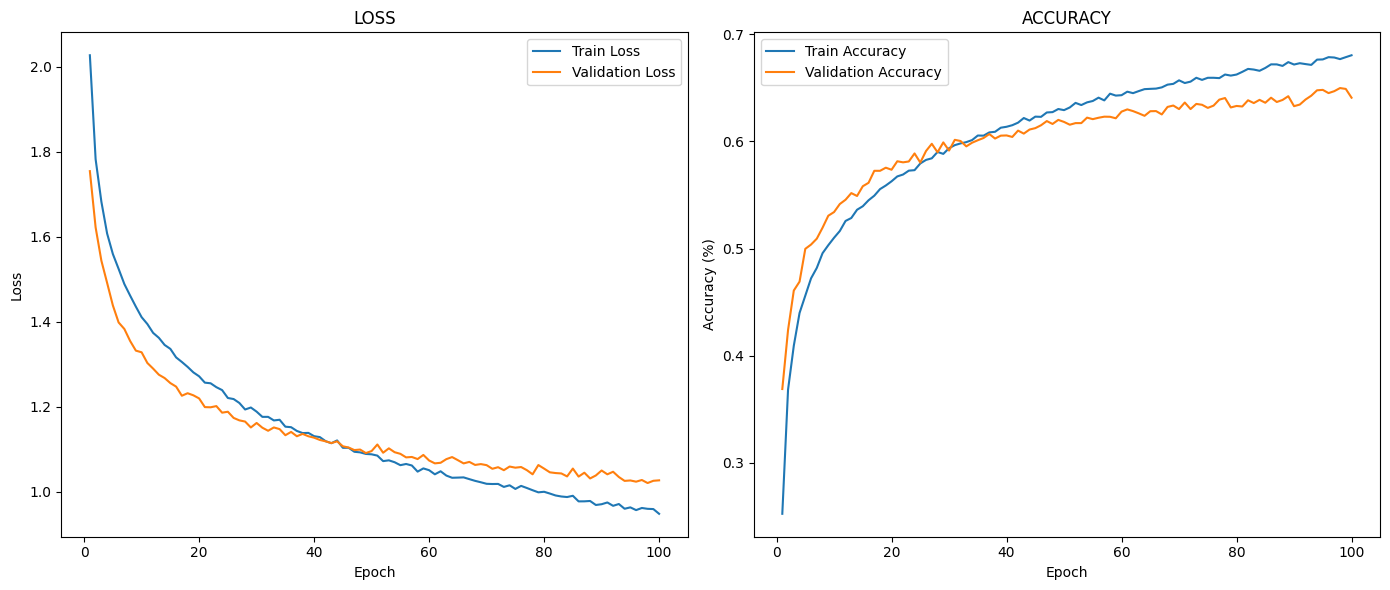

In [5]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_list4, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list4, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOSS')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_list4, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_acc_list4, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ACCURACY')
plt.legend()

plt.tight_layout()
plt.show()

### **Fourth Performance Review**

The training process shows encouraging progress with significant improvement in both training accuracy and validation accuracy.

Training Accuracy: Steadily increases from 25.41% to 68% across 100 epochs, indicating the model is effectively learning the data.

Validation Accuracy: Increases sharply, demonstrating the model generalizes well to unseen data to some extent.

Loss Function: Both training loss and validation loss decrease throughout the training process, the model is fitting the data better.

# **Fifth Take**

The validation stats are improved but not enough to get out of underfitting case. In this take, I consider use a model with more complexity and try to modify a different learning rate.
Things to do this take:
* Add more hidden layer and more neurals in each hidden layer.
* Add batch normalization to hold the model stable.
* Try different learning rate.
* Decrease the drop-out rate bacause less drop-out would take the model an oppotunity to learning effiency.

In [12]:
'''---------------NOTHING CHANGE BETWEEN THESE LINES-----------------'''
batch_size = 1024

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

org_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

augment = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=15),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augment_data = torchvision.datasets.CIFAR10(root='./augdata', train=True,
                                        download=True, transform=augment)

train_data = torch.utils.data.ConcatDataset([org_data, augment_data])

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset_size = len(train_data)
indices = list(range(dataset_size))
torch.manual_seed(42)
shuffle_indices = torch.randperm(dataset_size)

train_idx = shuffle_indices[:int(train_ratio * dataset_size)]
val_idx = shuffle_indices[int(train_ratio * dataset_size): int((train_ratio + val_ratio) * dataset_size)]
test_idx = shuffle_indices[int((train_ratio + val_ratio) * dataset_size):]

train_dataset = torch.utils.data.Subset(train_data, train_idx)
val_dataset = torch.utils.data.Subset(train_data, val_idx)
test_dataset = torch.utils.data.Subset(train_data, test_idx)

train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
val_sampler = torch.utils.data.sampler.SequentialSampler(val_dataset)
test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

'''------------------------------------------------'''


class FCNet_5take(nn.Module):
    def __init__(self):
        super(FCNet_5take, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)     # Batch Normalization
        self.fc2 = nn.Linear(1024, 1024)    # Add more hidden layer
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 32)
        self.fc8 = nn.Linear(32, 10)        
        self.dropout = nn.Dropout(0.2)      # Modify dropout rate


    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3) 
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc8(x), dim=1)
        return x

learning_rates = [0.001, 0.002, 0.004, 0.008, 0.01]
epochs = 50

vl = []
va = []
for learning_rate in learning_rates:
    print("Training with learning rate: ", learning_rate)
    model = FCNet_5take()

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
    criterion = nn.CrossEntropyLoss()

    val_loss_list5 = []
    val_acc_list5 = []
    train_loss_list5 = []
    train_acc_list5 = []

    best_val_acc = 0.0
    patience = 10
    current_patience = 0

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        correct_train = 0
        total_train = 0
        val_correct = 0
        val_total = 0
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if i % 100 == 99:
                train_loss = 0.0
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        model.eval()
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        train_loss = train_loss / len(train_loader)
        val_acc = val_correct / val_total
        train_acc = correct_train / total_train

        train_loss_list5.append(train_loss)
        train_acc_list5.append(train_acc)
        val_acc_list5.append(val_acc)
        val_loss_list5.append(val_loss)

        print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.3f} | Train Accuracy: {100 * train_acc:.2f} | Validation Loss: {val_loss:.3f} | Validation Accuracy: {100 * val_acc:.2f}")

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                print("Highest accuracy: ", best_val_acc * 100)
                break
    vl.append(val_loss_list5)
    va.append(val_acc_list5)
    print("\n")

Files already downloaded and verified
Files already downloaded and verified
Training with learning rate:  0.001
Epoch 1: Train Loss: 1.863 | Train Accuracy: 32.34 | Validation Loss: 1.625 | Validation Accuracy: 42.57
Epoch 2: Train Loss: 1.590 | Train Accuracy: 43.82 | Validation Loss: 1.512 | Validation Accuracy: 46.04
Epoch 3: Train Loss: 1.480 | Train Accuracy: 47.94 | Validation Loss: 1.401 | Validation Accuracy: 50.25
Epoch 4: Train Loss: 1.408 | Train Accuracy: 50.64 | Validation Loss: 1.357 | Validation Accuracy: 51.51
Epoch 5: Train Loss: 1.354 | Train Accuracy: 52.78 | Validation Loss: 1.302 | Validation Accuracy: 53.98
Epoch 6: Train Loss: 1.308 | Train Accuracy: 54.72 | Validation Loss: 1.287 | Validation Accuracy: 54.41
Epoch 7: Train Loss: 1.262 | Train Accuracy: 56.06 | Validation Loss: 1.255 | Validation Accuracy: 55.54
Epoch 8: Train Loss: 1.235 | Train Accuracy: 57.31 | Validation Loss: 1.210 | Validation Accuracy: 57.53
Epoch 9: Train Loss: 1.189 | Train Accuracy: 58.

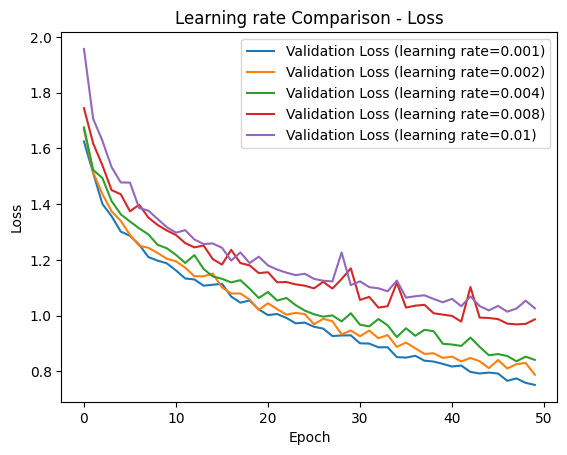

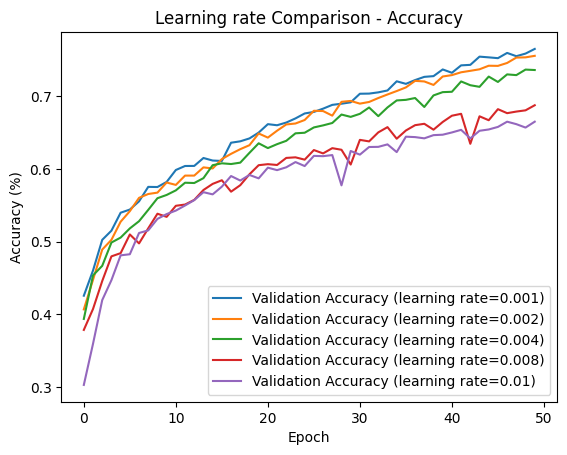

In [13]:
# Plot the learning curves for each learning rate value
for i, learning_rate in enumerate(learning_rates):
    plt.plot(vl[i], label=f'Validation Loss (learning rate={learning_rate})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning rate Comparison - Loss')
plt.legend()
plt.show()

# Plot the accuracy curves for each learning rate value
for i, learning_rate in enumerate(learning_rates):
    plt.plot(va[i], label=f'Validation Accuracy (learning rate={learning_rate})')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning rate Comparison - Accuracy')
plt.legend()
plt.show()

### **Fifth Performance Review**

The comparison showing that training process isn't better when raising the learning rate. The results encouraging progress with significant improvement in both training accuracy and validation accuracy (reach 85% and 76% when just pass 50 epochs).

In [14]:
'''---------------NOTHING CHANGE BETWEEN THESE LINES-----------------'''
batch_size = 1024

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

org_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

augment = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=15),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augment_data = torchvision.datasets.CIFAR10(root='./augdata', train=True,
                                        download=True, transform=augment)

train_data = torch.utils.data.ConcatDataset([org_data, augment_data])

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset_size = len(train_data)
indices = list(range(dataset_size))
torch.manual_seed(42)
shuffle_indices = torch.randperm(dataset_size)

train_idx = shuffle_indices[:int(train_ratio * dataset_size)]
val_idx = shuffle_indices[int(train_ratio * dataset_size): int((train_ratio + val_ratio) * dataset_size)]
test_idx = shuffle_indices[int((train_ratio + val_ratio) * dataset_size):]

train_dataset = torch.utils.data.Subset(train_data, train_idx)
val_dataset = torch.utils.data.Subset(train_data, val_idx)
test_dataset = torch.utils.data.Subset(train_data, test_idx)

train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
val_sampler = torch.utils.data.sampler.SequentialSampler(val_dataset)
test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

'''------------------------------------------------'''


class FCNet_6take(nn.Module):
    def __init__(self):
        super(FCNet_6take, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)     # Batch Normalization
        self.fc2 = nn.Linear(1024, 1024)    # Add more hidden layer
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 32)
        self.fc8 = nn.Linear(32, 10)        
        self.dropout = nn.Dropout(0.2)      # Modify dropout rate


    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3) 
        x = F.relu(self.fc1(x))
        x = self.bn1(x) 
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc8(x), dim=1)
        return x

learning_rate = 0.001
epochs = 500


model = FCNet_6take()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

val_loss_list6 = []
val_acc_list6 = []
train_loss_list6 = []
train_acc_list6 = []

best_val_acc = 0.0
patience = 10
current_patience = 0

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct_train = 0
    total_train = 0
    val_correct = 0
    val_total = 0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i % 100 == 99:
            train_loss = 0.0
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    train_loss = train_loss / len(train_loader)
    val_acc = val_correct / val_total
    train_acc = correct_train / total_train

    train_loss_list6.append(train_loss)
    train_acc_list6.append(train_acc)
    val_acc_list6.append(val_acc)
    val_loss_list6.append(val_loss)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.3f} | Train Accuracy: {100 * train_acc:.2f} | Validation Loss: {val_loss:.3f} | Validation Accuracy: {100 * val_acc:.2f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            print("Highest accuracy: ", best_val_acc * 100)
            break

print("Done!")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss: 1.863 | Train Accuracy: 32.34 | Validation Loss: 1.625 | Validation Accuracy: 42.57
Epoch 2: Train Loss: 1.590 | Train Accuracy: 43.82 | Validation Loss: 1.512 | Validation Accuracy: 46.04
Epoch 3: Train Loss: 1.480 | Train Accuracy: 47.94 | Validation Loss: 1.401 | Validation Accuracy: 50.25
Epoch 4: Train Loss: 1.408 | Train Accuracy: 50.64 | Validation Loss: 1.357 | Validation Accuracy: 51.51
Epoch 5: Train Loss: 1.354 | Train Accuracy: 52.78 | Validation Loss: 1.302 | Validation Accuracy: 53.98
Epoch 6: Train Loss: 1.308 | Train Accuracy: 54.72 | Validation Loss: 1.287 | Validation Accuracy: 54.41
Epoch 7: Train Loss: 1.262 | Train Accuracy: 56.06 | Validation Loss: 1.255 | Validation Accuracy: 55.54
Epoch 8: Train Loss: 1.235 | Train Accuracy: 57.31 | Validation Loss: 1.210 | Validation Accuracy: 57.53
Epoch 9: Train Loss: 1.189 | Train Accuracy: 58.78 | Validation Loss: 1.198 | Valida

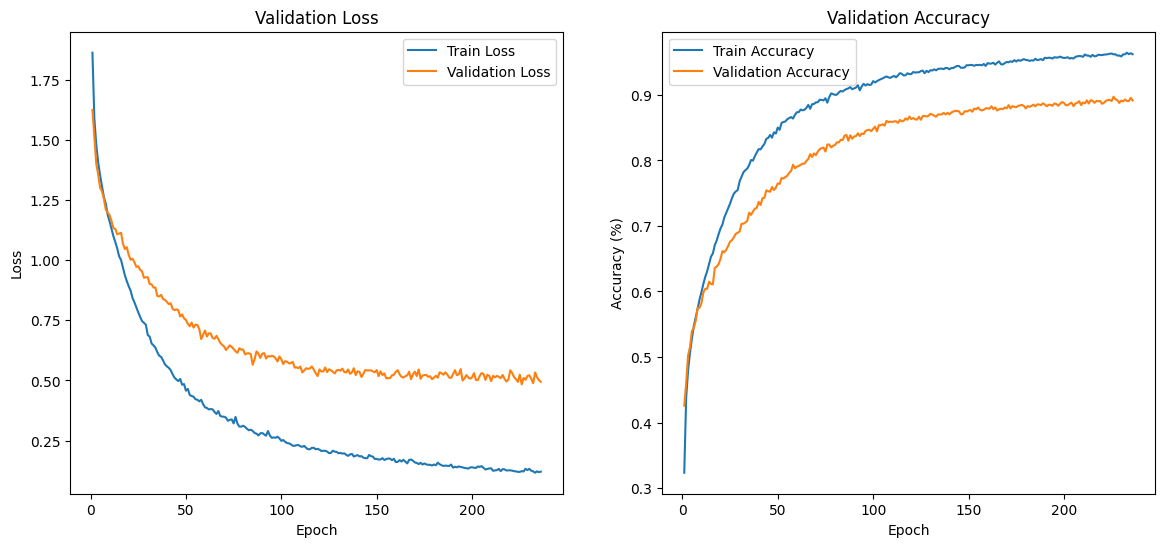

In [15]:
# Vẽ biểu đồ loss và accuracy kế nhau
plt.figure(figsize=(14, 6))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 2), train_loss_list6, label='Train Loss')
plt.plot(range(1, epoch + 2), val_loss_list6, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_acc_list6, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_acc_list6, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

Overview
Both training and validation accuracy show consistent improvement throughout the training process, suggesting effective learning. The relatively small gap between training and validation accuracy suggests the model is generalizing well on validate data.

Average Accuracy: 88.78%


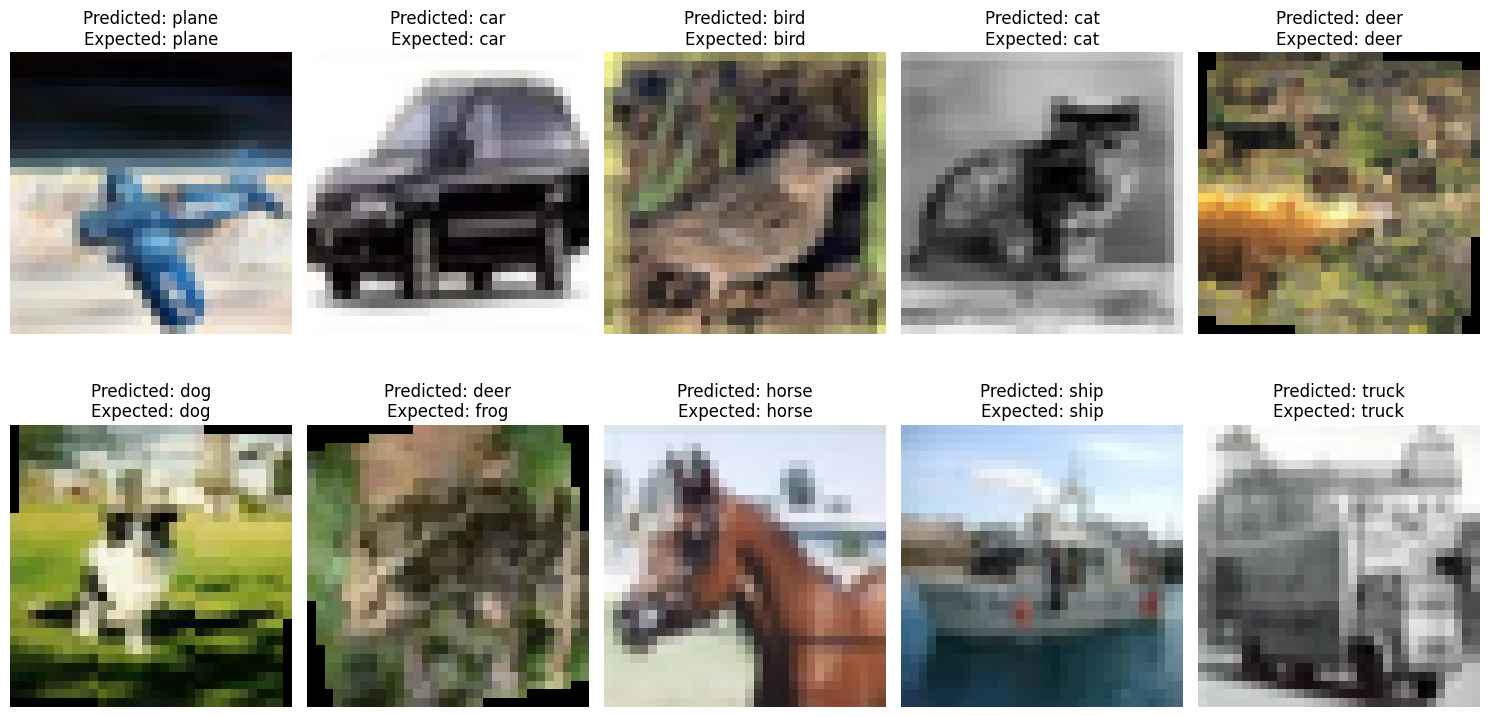

In [25]:
# Evaluate the model on the test set
avg_accuracy = 0
n = 9
for k in range(n):
    correct = 0
    total = 0
    predictions = []


    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
    avg_accuracy += correct / total
print('Average Accuracy: {:.2f}%'.format(100 * avg_accuracy / n))

# Display one image for each class with its predicted and expected labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')
class_images = {class_name: None for class_name in classes}
correct_predictions = {class_name: None for class_name in classes}

# Randomly select one image for each class
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            class_name = classes[labels[i]]
            if class_images[class_name] is None:
                class_images[class_name] = images[i]
                correct_predictions[class_name] = predicted[i].item()

# Display the images
plt.figure(figsize=(15, 8))
for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.transpose(image / 2 + 0.5, (1, 2, 0)))
    plt.title(f'Predicted: {classes[correct_predictions[class_name]]}\nExpected: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Conclusion

This training run showcases progress in model performance. Training accuracy reaches a commendable 66.65%, and validation accuracy peaks at 63.87%.  However, the slight dip in validation accuracy after epoch 90 suggests potential overfitting.

While FCNs have proven effective in various tasks, training them on CIFAR-10 presents some challenges for starters. There's a breakdown of the limitations and alternative approaches like: overfitting, vanishing gradients, computational cost,...

By understanding the limitations of FCNs and exploring alternative architectures and techniques, higher-level AI developers can achieve superior performance and generalization on tasks like CIFAR-10 while ensuring efficient resource utilization.